In [ ]:
import sys
import json

from data.loader import DataLoader
from data import preprocessor
import transformer_full
from libs import *
from models.evaluation import find_kappa, plot_results

In [4]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow)
keras.utils.set_random_seed(117)
tf.config.experimental.enable_op_determinism()

In [5]:
tf.__version__

'2.19.0'

# Data loading

In [ ]:
wind_turbine = input("Enter the wind turbine name: ")

In [ ]:
model_name = f"FT_{wind_turbine}"
project_folder = ".."
samples_per_day = 144
MA_window = samples_per_day * 1
MA_window_FPI = samples_per_day * 7

In [ ]:
# Read the wind turbine name from the json file
with open('../wind_turbines.json', 'r') as f:
    wind_turbines_names = json.load(f)

WT_name = wind_turbines_names[wind_turbine]

In [ ]:
years_of_data = [2020, 2021, 2022]
training_dates = pd.date_range(start='2020-06-01', end='2021-01-01', freq='min')
testing_dates = pd.date_range(start='2021-01-01', end='2022-03-01', freq='min')

In [ ]:
features_list = [
    wind_turbine + "_Gear Bearing Temp. Avg.",
    wind_turbine + "_Gear Bearing Temp.B Avg.",
    wind_turbine + "_Gear Bearing Temp.C Avg.",
    wind_turbine + "_Gear Oil Temp. Avg.",
    wind_turbine + "_Gear Oil Temp.Inlet Avg.",
    wind_turbine + "_Rotor RPM Avg."
]

In [ ]:
columns = [
    'gear_bearing_temp',
    'gear_bearing_temp_b',
    'gear_bearing_temp_c',
    'gear_oil_temp',
    'gear_oil_temp_inlet',
    'rotor_rpm_avg'
]

In [ ]:
# Load the data
data_loader = DataLoader(
    wind_turbine=wind_turbine,
    years=years_of_data,
    features_list=features_list,
    column_names=columns
)
data = data_loader.load_from_pickle(path=project_folder)

In [ ]:
data = preprocessor.clean_data(data)
data = preprocessor.smooth_data(data, rolling_window=MA_window)
data = preprocessor.remove_outliers(data, threshold=5)
data = preprocessor.feature_selection(data)

## Train-test Split

In [13]:
# Selecting training and testing data
training_set = data[data['date'].isin(training_dates)]
testing_set = data[data['date'].isin(testing_dates)]

In [14]:
scaler = MinMaxScaler()
scaler.fit(training_set.iloc[:,1:])

training_set.iloc[:,1:]=scaler.transform(training_set.iloc[:,1:])
testing_set.iloc[:,1:]=scaler.transform(testing_set.iloc[:,1:])

In [15]:
n_steps = samples_per_day
x_train, y_train = preprocessor.split_sequences(training_set, n_steps)
print(x_train.shape, y_train.shape)

(30673, 144, 5) (30673,)


In [16]:
x_test, y_test = preprocessor.split_sequences(testing_set, n_steps)
print(x_test.shape, y_test.shape)

(60912, 144, 5) (60912,)


# Model definition and training

In [ ]:
# load the model and prepare for continuing training
model = keras.models.load_model(f'{project_folder}/Models/{pre_trained_model}.keras')

model.compile(loss="mean_squared_error",
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
)

callbacks = [keras.callbacks.ModelCheckpoint(f"{project_folder}/Models/Checkpoints/FT_{wind_turbine}_{MA_window}_ckpt.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    #validation_data=(x_val, y_val),
    shuffle=False,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - loss: 4.4027e-04 - val_loss: 1.8170e-04
Epoch 2/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 3.0192e-04 - val_loss: 1.8360e-04
Epoch 3/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.9476e-04 - val_loss: 2.0542e-04
Epoch 4/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 2.9778e-04 - val_loss: 1.5811e-04
Epoch 5/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 2.9123e-04 - val_loss: 1.5273e-04
Epoch 6/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.9792e-04 - val_loss: 1.3103e-04
Epoch 7/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.9197e-04 - val_loss: 1.1828e-04
Epoch 8/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.8855e-04 - val_loss: 1.3086e-04
Epoch 9/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.8962e-04 - val_loss: 9.9085e-05
Epoch 10/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.8381e-04 - val_loss: 1.1924e-04
Epoch 11/30
384/384 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save(f'{project_folder}/Models/FT_{wind_turbine}_{MA_window}.keras')
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{project_folder}/Training_history/FT_{wind_turbine}_{MA_window}_history.csv', index=False)

loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

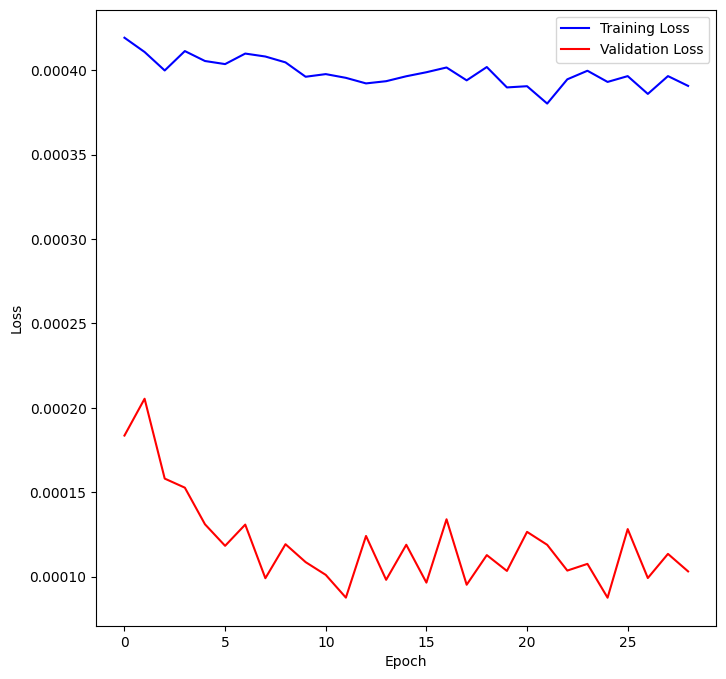

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=loss, ax = ax, color="b", label='Training Loss')
sns.lineplot(data=val_loss, ax = ax, color="r", label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# save plot as image
plt.savefig(f'{project_folder}/Training_plots/FT_{wind_turbine}_{MA_window}_loss.png')

# Model evaluation

In [17]:
model = keras.models.load_model(f'{project_folder}/Models_trans/FT_{wind_turbine}_{MA_window}.keras')

In [18]:
y_train_pred = model.predict(x_train)

959/959 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step


In [19]:
y_pred = model.predict(x_test)

1904/1904 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step


In [20]:
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)

In [21]:
# There is a shift of n_steps between the predictions and the true values
n_steps = 2

In [22]:
training_dates = data[data['date'].isin(training_dates)].date
testing_dates = data[data['date'].isin(testing_dates)].date

In [23]:
train_results = pd.DataFrame({'date':training_dates[samples_per_day + n_steps:],
                              'Real':y_train[:-1*n_steps],
                              'Predicted': y_train_pred[n_steps:]})
train_results

,date,Real,Predicted
21603,2020-06-02 00:20:00,0.566789,0.572574
21604,2020-06-02 00:30:00,0.567063,0.572626
21605,2020-06-02 00:40:00,0.567521,0.572739
21606,2020-06-02 00:50:00,0.567978,0.572888
21607,2020-06-02 01:00:00,0.568710,0.573106
...,...,...,...
52269,2020-12-31 23:20:00,0.643916,0.645522
52270,2020-12-31 23:30:00,0.643184,0.644915
52271,2020-12-31 23:40:00,0.642177,0.644085
52272,2020-12-31 23:50:00,0.641171,0.643233


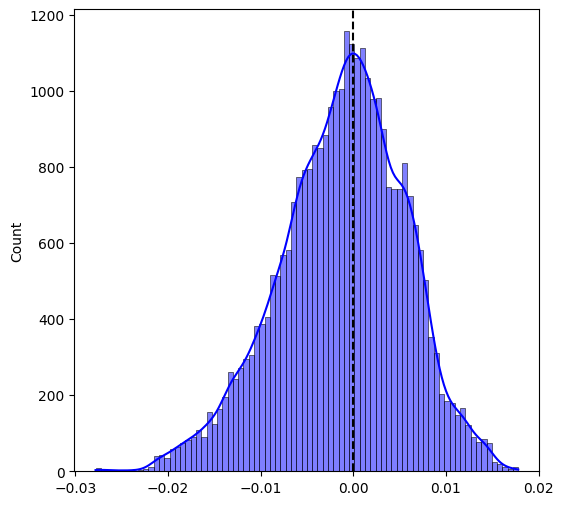

In [24]:
# Checking for bias in the residuals distribution plot
residuals = train_results['Real'] - train_results['Predicted']

fig,ax = plt.subplots(figsize=(6,6))
sns.histplot(residuals, kde=True, color='blue', ax=ax)
plt.axvline(x=0, color='black', linestyle='--')

Biased mean:  -0.0012061128445131544


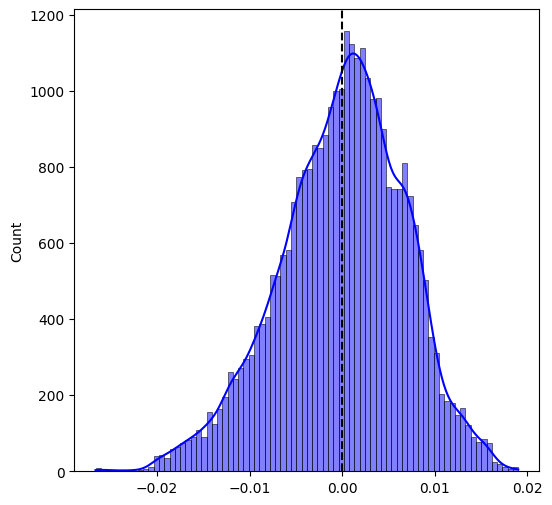

In [25]:
biased_mean = np.mean(train_results['Real'] - train_results['Predicted'])
print("Biased mean: ", biased_mean)

train_results['Predicted'] += biased_mean

# Plotting the distribution of the residuals again
residuals = train_results['Real'] - train_results['Predicted']

fig,ax = plt.subplots(figsize=(6,6))
sns.histplot(residuals, kde=True, color='blue', ax=ax)
plt.axvline(x=0, color='black', linestyle='--')

In [26]:
train_results['Residual'] = abs(train_results.Real - train_results.Predicted)

In [27]:
window = samples_per_day * 7   #Averaged per week
#averaged_error = train_results.Residual.rolling(window = window).mean()[window-1:]
train_results['Residual'] = train_results['Residual'].ewm(span=window).mean()

<Axes: xlabel='Residual', ylabel='Count'>

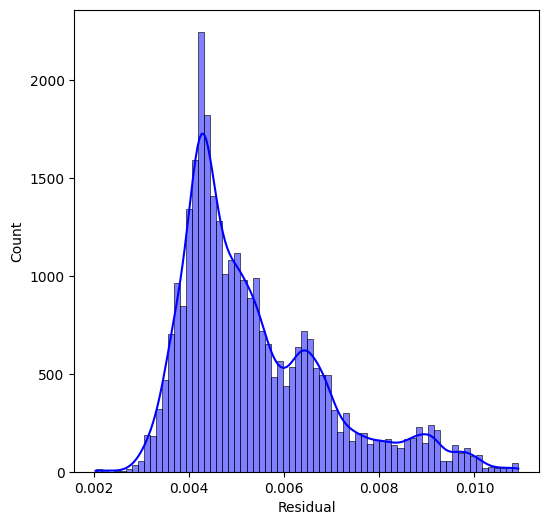

In [28]:
# Plotting the residuals distribution
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(train_results['Residual'], kde=True, color='blue', ax=ax)

### Threshold selection

In [29]:
# Calculating median and std for threshold definition, as residual distribution is right skewed
median_error = train_results.Residual.median()
std_error = train_results.Residual.std()

In [30]:
selected_kappa = find_kappa(train_results, median_error, std_error)

Number of outliers found for threshold k=3.0: 624
Number of outliers found for threshold k=3.2: 328
Number of outliers found for threshold k=3.4: 137
Number of outliers found for threshold k=3.6: 87
Number of outliers found for threshold k=3.8: 44
Number of outliers found for threshold k=4.0: 0
Optimal kappa value found: 4.0


In [31]:
threshold = median_error + selected_kappa*std_error

## Test set

In [32]:
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

In [33]:
test_result = pd.DataFrame({'date':testing_dates[samples_per_day + n_steps:],
                          'Real':y_test[:-1*n_steps],
                          'Predicted': y_pred[n_steps:]})
test_result

,date,Real,Predicted
52419,2021-01-02 00:20:00,0.618756,0.627501
52420,2021-01-02 00:30:00,0.619213,0.628173
52421,2021-01-02 00:40:00,0.619305,0.628739
52422,2021-01-02 00:50:00,0.619305,0.629231
52423,2021-01-02 01:00:00,0.619579,0.629678
...,...,...,...
113324,2022-02-28 23:10:00,0.943001,0.919889
113325,2022-02-28 23:20:00,0.945563,0.922000
113326,2022-02-28 23:30:00,0.948216,0.924171
113327,2022-02-28 23:40:00,0.950869,0.926392


In [34]:
score = np.sqrt(metrics.mean_squared_error(test_result.Real,test_result.Predicted))
print("Score RMSE: {}".format(score))

Score RMSE: 0.007418952876872936


In [35]:
test_result['Predicted'] += biased_mean

In [36]:
test_result['Residual'] = abs(test_result['Real'] - test_result['Predicted'])

In [37]:
window = samples_per_day * 7  #Averaged per week
#averaged_error = test_result.Residual.rolling(window = window).mean()[window-1:]
test_result['Residual'] = test_result['Residual'].ewm(span=window).mean()

## Checking alarm activations

In [38]:
window_size = samples_per_day * 7
exceedances = test_result['Residual'].rolling(window=window_size).apply(lambda x: all(x > threshold), raw=True)
test_result['Alarm'] = exceedances

In [39]:
test_result.loc[test_result['Alarm'] == 1.0]

,date,Real,Predicted,Residual,Alarm


In [40]:
if test_result.loc[test_result['Alarm'] == 1.0].shape[0] == 0:
    print("No alarm was triggered")
else:
    alarm_date = str(test_result.loc[test_result['Alarm'] == 1.0]['date'].iloc[0])
    print(f'Alarm triggered at {alarm_date}')

No alarm was triggered


In [41]:
alarm_df = pd.DataFrame({
    'date': data[data['date'].isin(pd.date_range(start='2020-06-01', end='2022-03-01', freq='min'))].date,
})

In [42]:
alarm_df = pd.merge(alarm_df, test_result[['date', 'Alarm']], on='date', how='left')
alarm_df['Alarm'] = alarm_df['Alarm'].fillna(0)

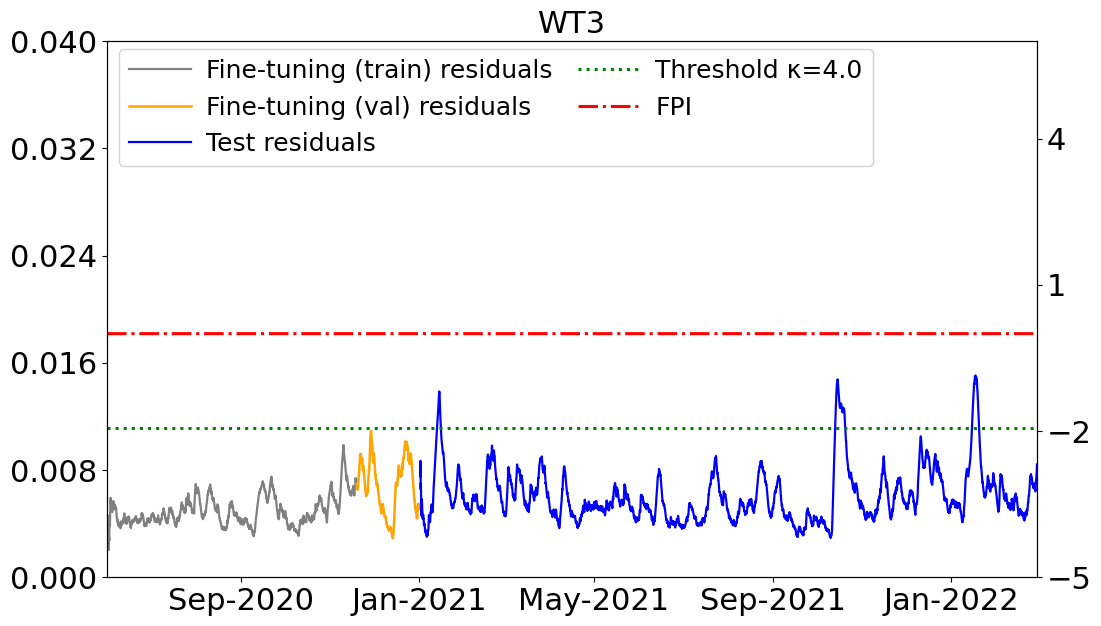

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# ====== Ajusta estos valores según tu caso ======
training_split = 0.8
alarm_mode = "dynamic"        # "dynamic" | "constant" | "none"
fontsize = 22                 # ticks / título
legend_fontsize = 18          # <<< SOLO leyenda (ajusta 12–16)
figsize = (12, 8)

colors = {
    'train': 'gray',
    'validation': 'orange',
    'test': 'blue',
    'threshold': 'green',
    'alarm': 'red'
}

# Deben existir en tu notebook:
# train_results, test_result, alarm_df, threshold, WT_name, selected_kappa

# ====== Asegurar que date sea datetime ======
train_results = train_results.copy()
test_result = test_result.copy()
alarm_df = alarm_df.copy()

train_results["date"] = pd.to_datetime(train_results["date"])
test_result["date"] = pd.to_datetime(test_result["date"])
alarm_df["date"] = pd.to_datetime(alarm_df["date"])

# ====== Split train/val ======
train_size = int(train_results.shape[0] * training_split)

# ====== Figura y eje 1 ======
fig, ax1 = plt.subplots(figsize=figsize)

sns.lineplot(
    data=train_results.iloc[:train_size], x="date", y="Residual",
    ax=ax1, color=colors["train"], linestyle='solid', linewidth=1.6,
    label="Fine-tuning (train) residuals"
)

sns.lineplot(
    data=train_results.iloc[train_size:], x="date", y="Residual",
    ax=ax1, color=colors["validation"], linestyle="solid", linewidth=1.8,
    label="Fine-tuning (val) residuals"
)

sns.lineplot(
    data=test_result, x="date", y="Residual",
    ax=ax1, color=colors["test"], linestyle="solid", linewidth=1.6,
    label="Test residuals"
)

ax1.axhline(
    y=threshold,
    color=colors["threshold"],
    linestyle=":",
    linewidth=2.2,
    label=f"Threshold κ={selected_kappa}"
)

# ====== Líneas verticales con leyenda (solo para WT8) ======
if WT_name == "WT8":
    ax1.axvline(
        x=pd.to_datetime("2021-10-18"),
        color="pink", linestyle="--", linewidth=2,
        label="October 18, 2021:\nFPI activation"     # <<< salto de línea
    )
    ax1.axvline(
        x=pd.to_datetime("2022-02-23"),
        color="brown", linestyle="--", linewidth=2,
        label="February 23, 2022:\nConfirmed fault"   # <<< salto de línea
    )
    #ax1.axvline(x=pd.to_datetime("2021-08-10"), color="black", linestyle="--", linewidth=2)

# ====== Eje 2 (derecho) ======
ax2 = ax1.twinx()

if alarm_mode == "constant":
    ax2.axhline(y=0, color=colors["alarm"], linewidth=2.2, label="FPI")
elif alarm_mode == "dynamic":
    sns.lineplot(
        data=alarm_df, x="date", y="Alarm",
        ax=ax2, color=colors["alarm"], linestyle="dashdot", linewidth=2.2,
        label="FPI"
    )

# ====== Leyendas combinadas ======
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    ncol=2,
    frameon=True,
    framealpha=0.9,
    fontsize=legend_fontsize,
    loc="upper left",
    bbox_to_anchor=(0.01, 0.99),  # <<< mueve a la derecha (prueba 0.10–0.20)
    borderaxespad=0.1,
    columnspacing=1.0,
    handlelength=2.5,
    handletextpad=0.6
)

if ax2.get_legend():
    ax2.get_legend().remove()

# ====== Estética ======
ax1.set_xlabel("")
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.tick_params(axis="x", labelsize=fontsize)
ax1.tick_params(axis="y", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)
ax1.set_title(WT_name, fontsize=fontsize)

# ====== Eje Y izquierdo ======
ax1_y_range = np.arange(0.0, 0.0401, 0.008)
ax1.set_ylim(0, 0.04)
ax1.set_yticks(ax1_y_range)

# ====== Eje derecho (ajusta si lo necesitas) ======
ax2.set_ylim(-5, 6)
ax2.set_yticks(np.arange(-5, 7, 3))

# ====== X ticks: Jan, May, Sep ======
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 5, 9], bymonthday=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax1.xaxis.set_minor_locator(mticker.NullLocator())
ax1.margins(x=0)

# ====== Layout (IMPORTANTE: solo una vez) ======
fig.subplots_adjust(top=0.78)   # <<< deja espacio arriba para la leyenda
plt.show()